# Análise e Modelagem de Sobrevivência no Titanic

Este notebook tem como objetivo realizar uma análise exploratória dos dados do Titanic, pré-processar as features, treinar um modelo de Machine Learning para prever a sobrevivência de passageiros e avaliar seu desempenho.

## 1. Importação de Bibliotecas Essenciais

Nesta seção, importamos todas as bibliotecas Python necessárias para as etapas de manipulação de dados, visualização, modelagem e avaliação.

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shap
plt.style.use('seaborn-v0_8-colorblind')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Carregamento dos Dados

Carregamos o dataset de treinamento do Titanic a partir do arquivo CSV. Definimos também a coluna 'Survived' como nossa variável alvo para a predição.

In [32]:
TRAIN_DATA_PATH = "../data/train.csv"

titanic_data = pd.read_csv(TRAIN_DATA_PATH)

target = "Survived"

## 3. Análise Exploratória de Dados (AED)

### 3.1. Visão Geral dos Dados

In [33]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [34]:
titanic_data.shape

(891, 12)

In [35]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 3.2. Distribuição da Variável Alvo (`Survived`)

Analisamos a distribuição da variável 'Survived' para entender a proporção de sobreviventes e não sobreviventes no dataset. Isso é importante para identificar desbalanceamento de classes.

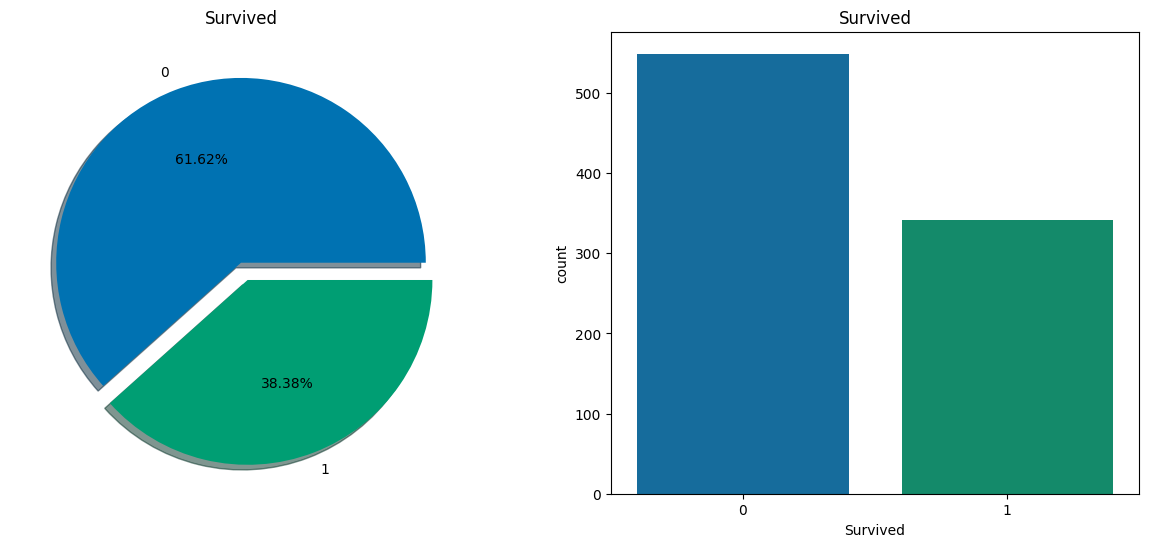

In [36]:
f,ax=plt.subplots(1,2,figsize=(15,6))
titanic_data[target].value_counts().plot.pie(explode=[0,0.1],autopct='%.2f%%',ax=ax[0],shadow=True)
ax[0].set_title(target)
ax[0].set_ylabel('')
sns.countplot(data=titanic_data, x=target,ax=ax[1])
ax[1].set_title(target)
plt.show()

In [37]:
titanic_data.groupby(['Sex',target])[target].count()


Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

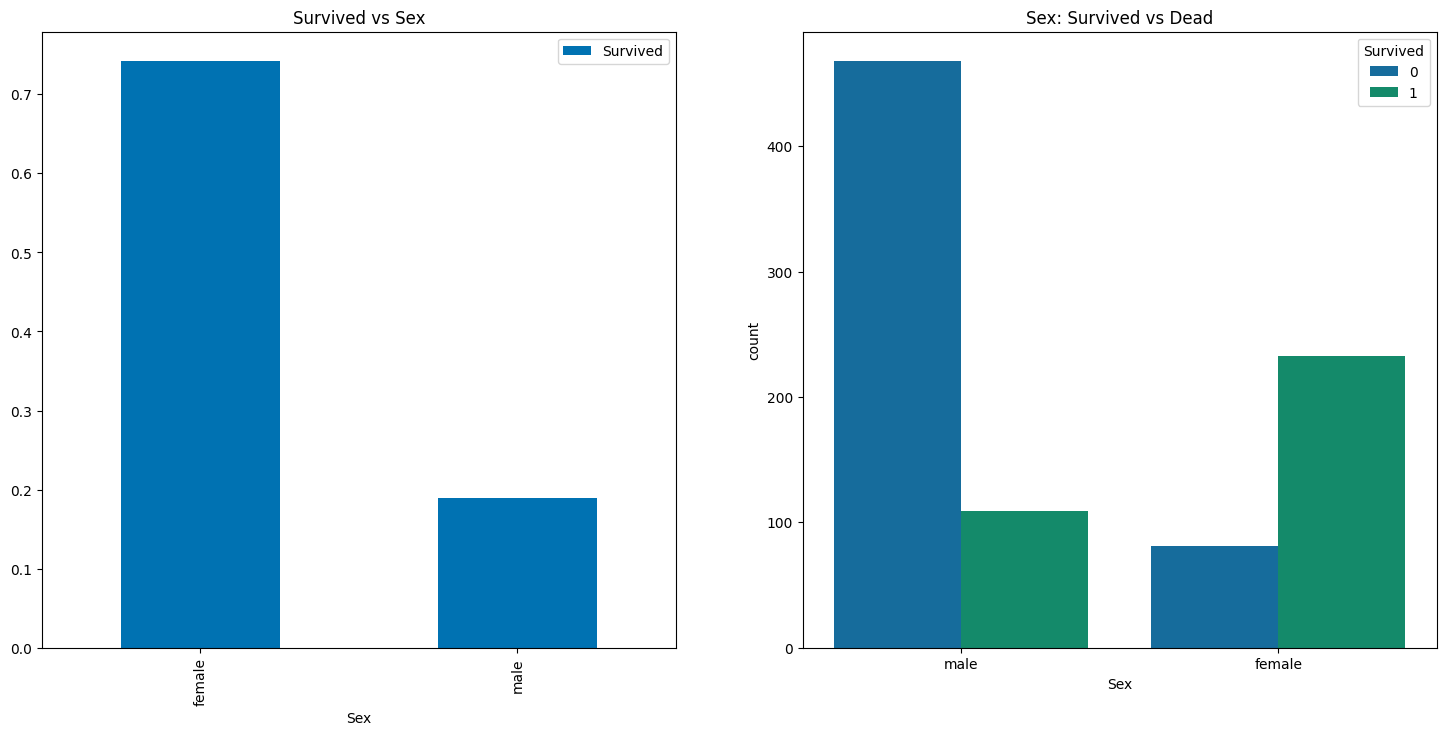

In [38]:
f,ax=plt.subplots(1,2,figsize=(18,8))
titanic_data[['Sex', target]].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(data=titanic_data, x='Sex',hue=target,ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

In [39]:
pd.crosstab(titanic_data.Pclass,titanic_data[target],margins=True).style.background_gradient(cmap='Blues')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


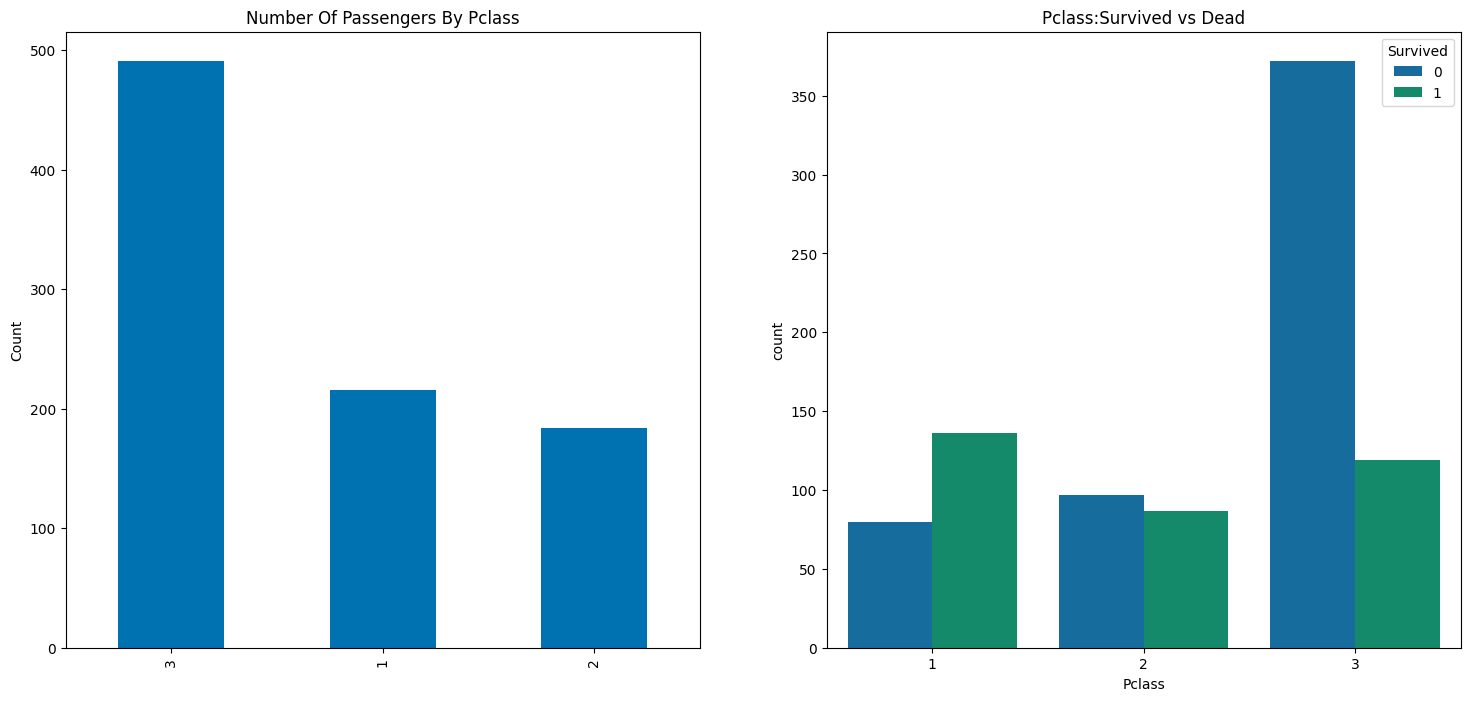

In [40]:
f,ax=plt.subplots(1,2,figsize=(18,8))
titanic_data['Pclass'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot(data=titanic_data,x='Pclass',hue='Survived',ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

In [41]:
print('Oldest Passenger was of:',titanic_data['Age'].max(),'Years')
print('Youngest Passenger was of:',titanic_data['Age'].min(),'Years')
print('Average Age on the ship:',titanic_data['Age'].mean(),'Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


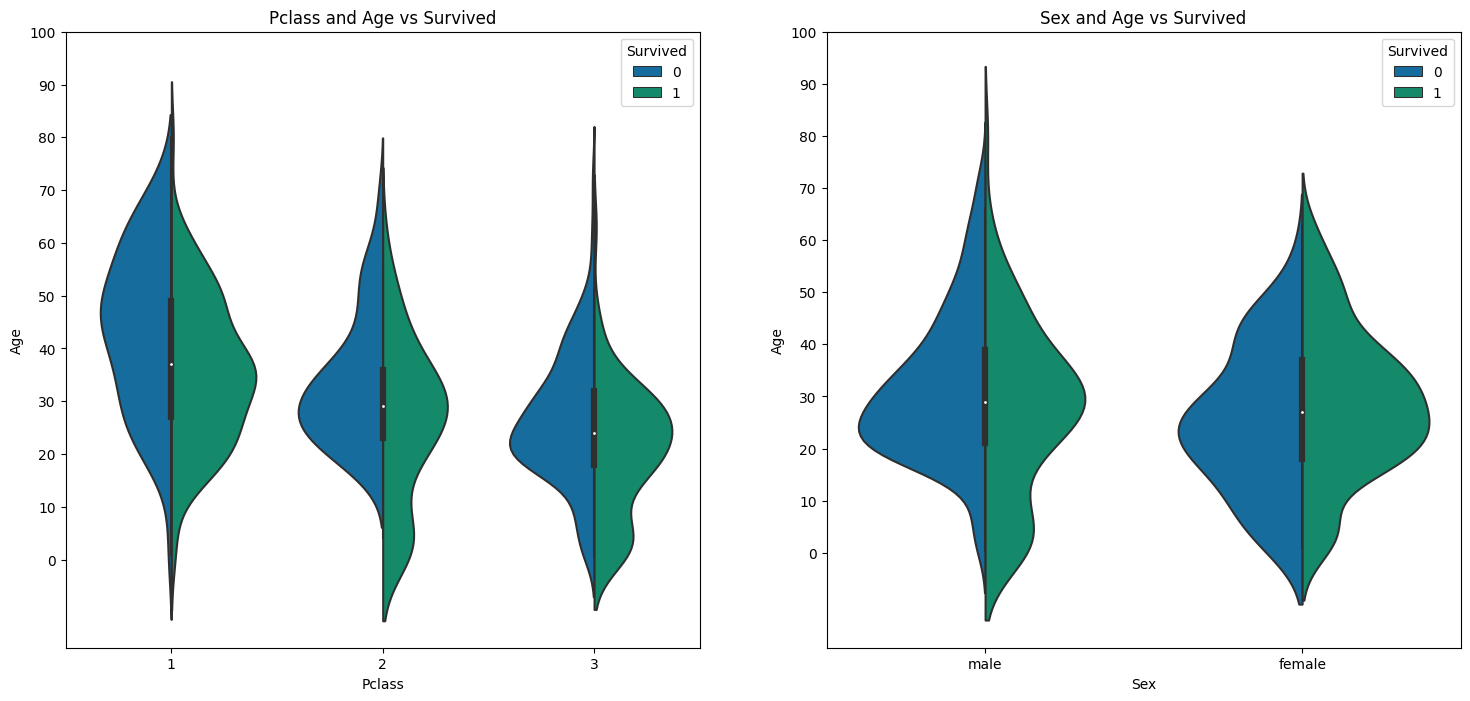

In [42]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot(x="Pclass",y="Age", hue="Survived", data=titanic_data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot(x="Sex",y="Age", hue="Survived", data=titanic_data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

## 4. Engenharia de Features

Criamos novas features a partir das existentes para melhorar o desempenho do modelo.

### 4.1. Extração e Agrupamento de Títulos

Extraímos os títulos dos nomes dos passageiros (ex: Mr., Miss., Mrs.) e os agrupamos em categorias mais amplas para reduzir a cardinalidade e capturar padrões.

In [43]:
def extract_title(name: str):
    match = re.search('([A-Za-z]+)\.', name)
    if match:
        return match.group(1).strip()
    return "Unknown"

titanic_data['Title'] = titanic_data['Name'].apply(extract_title)

In [44]:
pd.crosstab(titanic_data.Title,titanic_data.Sex).T.style.background_gradient(cmap='Blues')

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [45]:
titanic_data['Title'] = titanic_data['Title'].replace(['Dr', 'Major', 'Don', 'Sir', 'Capt'], 'Mr')
titanic_data['Title'] = titanic_data['Title'].replace(['Mlle', 'Mme', 'Ms'], 'Miss')
titanic_data['Title'] = titanic_data['Title'].replace(['Lady', 'Countess'], 'Mrs')
titanic_data['Title'] = titanic_data['Title'].replace(['Jonkheer', 'Col', 'Rev'], 'Other')

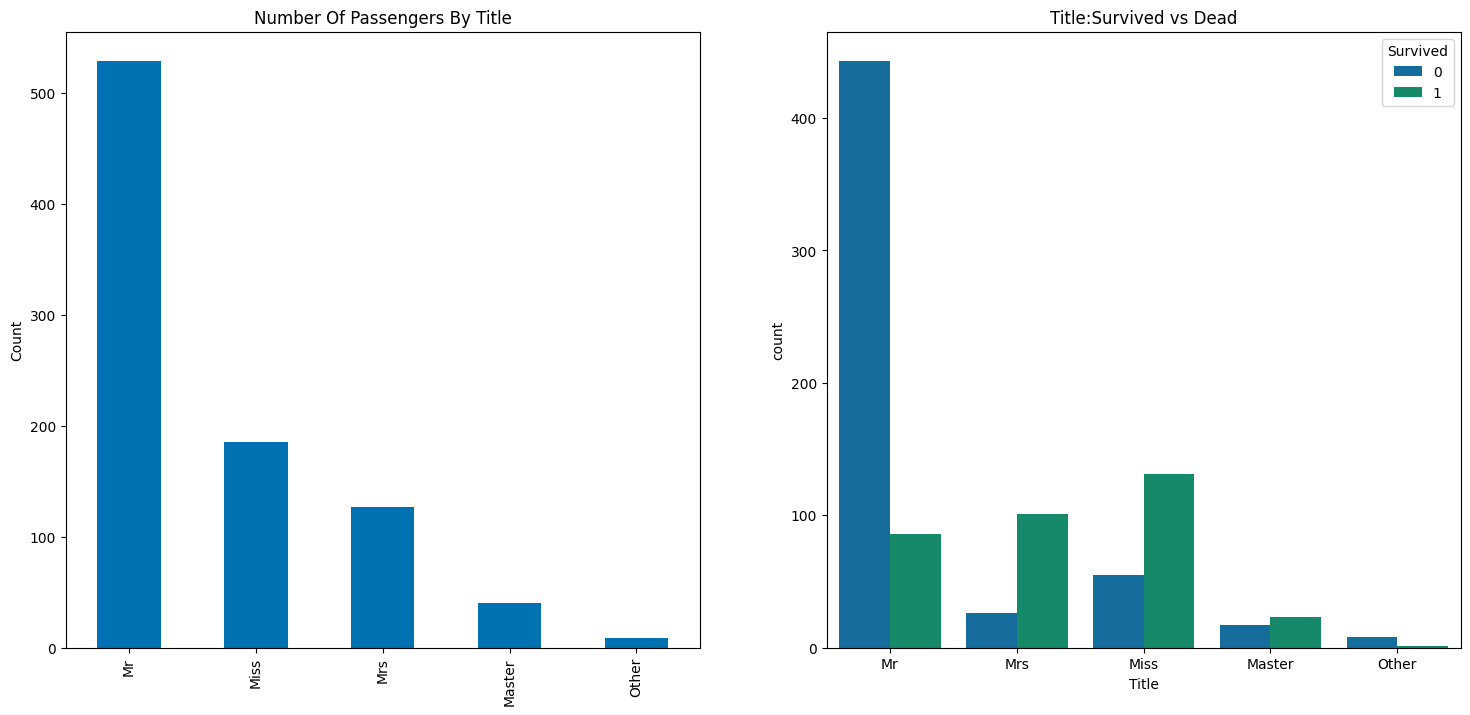

In [46]:
f,ax=plt.subplots(1,2,figsize=(18,8))
titanic_data['Title'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Number Of Passengers By Title')
ax[0].set_ylabel('Count')
sns.countplot(data=titanic_data,x='Title',hue='Survived',ax=ax[1])
ax[1].set_title('Title:Survived vs Dead')
plt.show()

### 4.2. `FamilySize` e `IsAlone`

* **`FamilySize`**: Soma de irmãos/cônjuges (`SibSp`), pais/filhos (`Parch`) e o próprio passageiro (adicionando 1).
* **`IsAlone`**: Variável binária que indica se o passageiro estava viajando sozinho (`FamilySize == 1`).

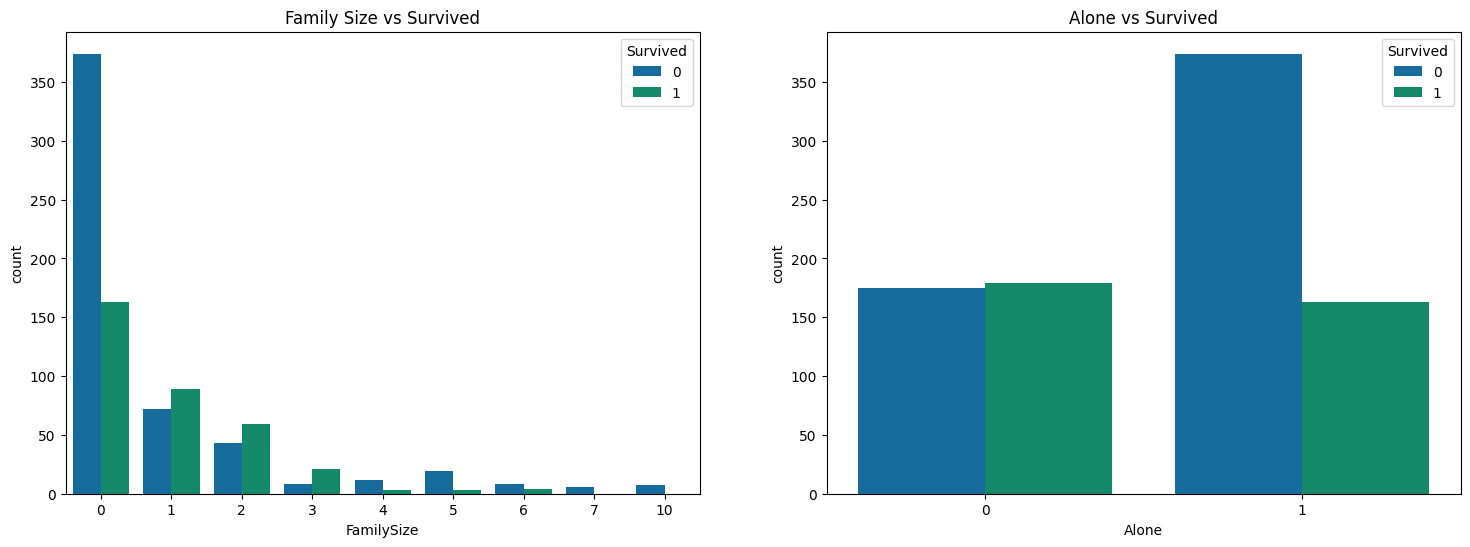

In [47]:
titanic_data['FamilySize'] = titanic_data['Parch'] + titanic_data['SibSp']
titanic_data['Alone'] = (titanic_data['FamilySize'] == 0).astype(int)

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.countplot(x='FamilySize',hue='Survived',data=titanic_data,ax=ax[0])
ax[0].set_title('Family Size vs Survived')
sns.countplot(x='Alone',hue='Survived',data=titanic_data,ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()

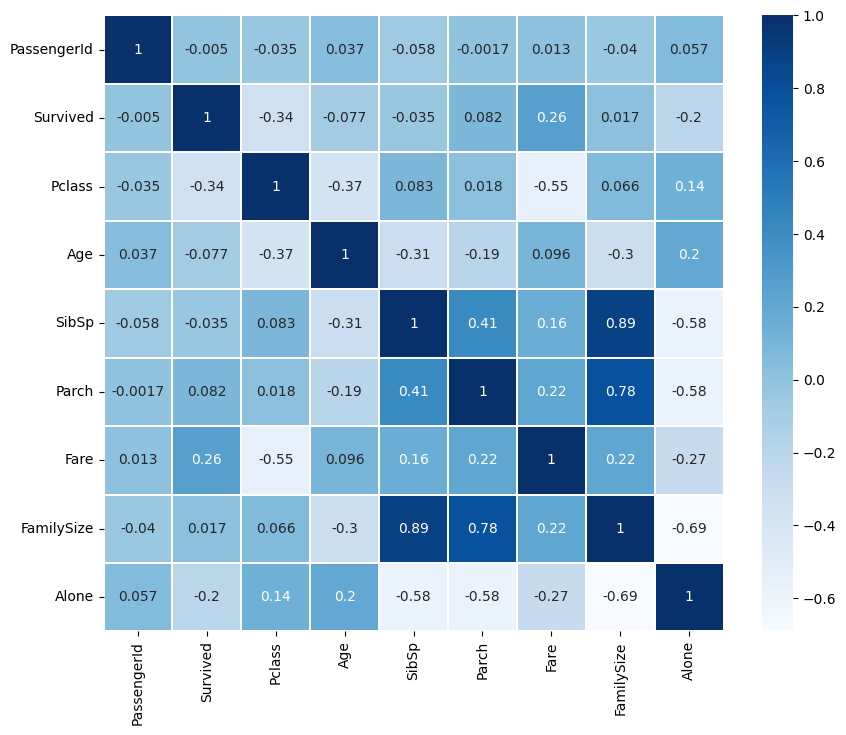

In [48]:
sns.heatmap(titanic_data.corr(),annot=True,cmap="Blues",linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

## Model training

In [49]:
features = ["Pclass", "Sex", "SibSp", "FamilySize", "Title", "Alone", "Fare"]

y = titanic_data[target]
X = pd.get_dummies(titanic_data[features])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [50]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [51]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.76      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



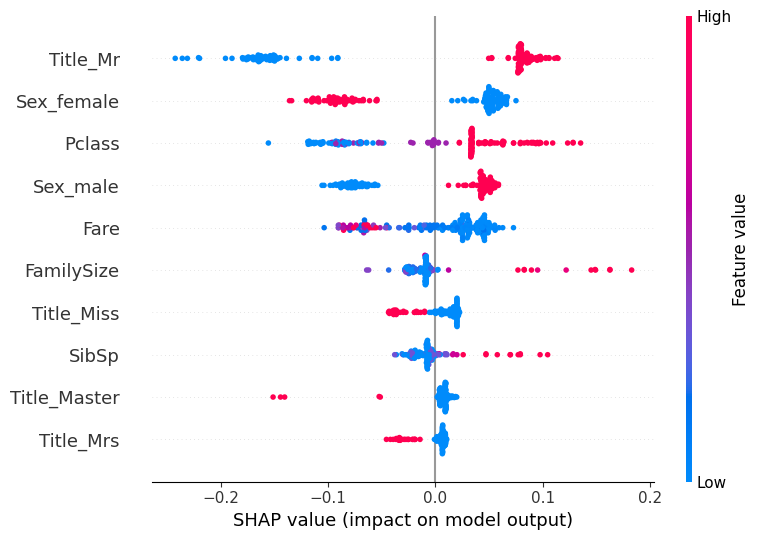

In [52]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[0], X_test, max_display=10)

In [54]:
X_train.columns

Index(['Pclass', 'SibSp', 'FamilySize', 'Alone', 'Fare', 'Sex_female',
       'Sex_male', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Other'],
      dtype='object')

In [53]:
joblib.dump(model, '../src/models/titanic_model.pkl')

['../src/models/titanic_model.pkl']